In [42]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cmocean
import xclim as xc

from unseen import fileio

## Find wettest events

In [2]:
rx15day_file = '/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region.zarr.zip'

In [3]:
rx15day_ds = fileio.open_dataset(rx15day_file)

In [4]:
rx15day_ds

<xarray.Dataset>
Dimensions:     (ensemble: 96, init_date: 52, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
    event_time  (init_date, lead_time, ensemble) <U28 dask.array<chunksize=(52, 11, 96), meta=np.ndarray>
  * init_date   (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 52), meta=np.ndarray>
Data variables:
    pr          (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 11, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Tue Jan 03 10:42:58 2023: /g/data/xv83/dbi599/miniconda3/envs...
    title:      AccessOcean-AM2

In [5]:
rx15day_df = rx15day_ds['pr'].to_dataframe()

In [8]:
rx15day_df = rx15day_df.dropna()

In [73]:
rx15day_df

event_time                 time  \
init_date           lead_time ensemble                                    
1995-05-01 00:00:00 1         1         1996-01-23  1996-05-01 12:00:00   
                              2         1996-02-21  1996-05-01 12:00:00   
                              3         1995-12-10  1996-05-01 12:00:00   
                              4         1996-03-03  1996-05-01 12:00:00   
                              5         1995-09-19  1996-05-01 12:00:00   
...                                            ...                  ...   
2020-11-01 00:00:00 9         92        2030-02-03  2029-11-01 12:00:00   
                              93        2029-12-28  2029-11-01 12:00:00   
                              94        2029-12-17  2029-11-01 12:00:00   
                              95        2030-04-26  2029-11-01 12:00:00   
                              96        2030-03-22  2029-11-01 12:00:00   

                                                pr  
init_date           lead_time ensemble              
1995-05-01 00:00:00 1         1          97.194399  
                              2         158.678279  
                              3         142.830538  
                              4         139.639970  
                              5          92.458357  
...                                            ...  
2020-11-01 00:00:00 9         92         77.183919  
                              93        119.817343  
                              94         98.297948  
                              95        189.280392  
                              96        218.817521  

[44928 rows x 3 columns]

In [9]:
selection = rx15day_df['pr'] > 200

In [11]:
wet_rx15day_df = rx15day_df[selection]

In [13]:
wet_rx15day_df.sort_values(by=['pr'], ascending=False)

,,,event_time,time,pr
init_date,lead_time,ensemble,,,
2011-11-01 00:00:00,4,30,2016-02-17,2015-11-01 12:00:00,342.611730
2000-05-01 00:00:00,7,85,2007-03-13,2007-05-01 12:00:00,338.352156
1998-05-01 00:00:00,1,9,1998-12-16,1999-05-01 12:00:00,317.690931
2004-11-01 00:00:00,9,60,2014-03-25,2013-11-01 12:00:00,316.928423
1999-05-01 00:00:00,6,80,2004-12-21,2005-05-01 12:00:00,305.218342
...,...,...,...,...,...
2007-11-01 00:00:00,9,47,2017-04-26,2016-10-31 12:00:00,200.085541
2010-05-01 00:00:00,4,90,2014-01-07,2014-05-01 12:00:00,200.083551
1997-05-01 00:00:00,7,88,2004-07-01,2004-05-01 12:00:00,200.076684


In [71]:
# init_date, ensemble, event_time

events = [
    ('20111101', 30, '2016-02-17'),
    ('20000501', 85, '2007-03-13'),
    ('19980501', 9, '1998-12-16'),
    ('20041101', 60, '2014-03-25'),
]

## Plot circulation

In [56]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_ylim(-55, 10)
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

20111101 30 2016-02-17


/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


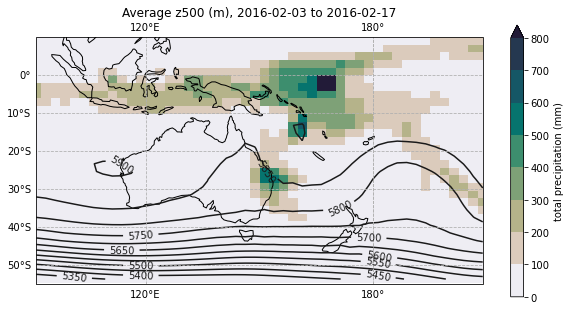

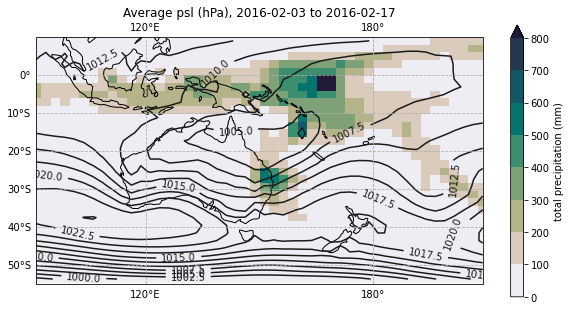

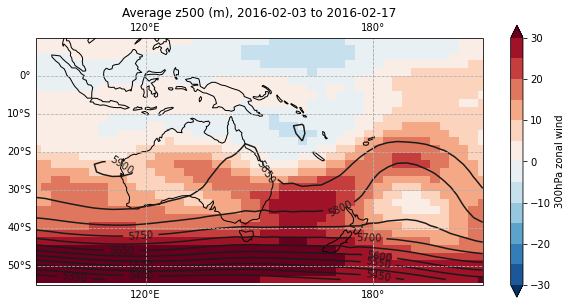

20000501 85 2007-03-13


/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


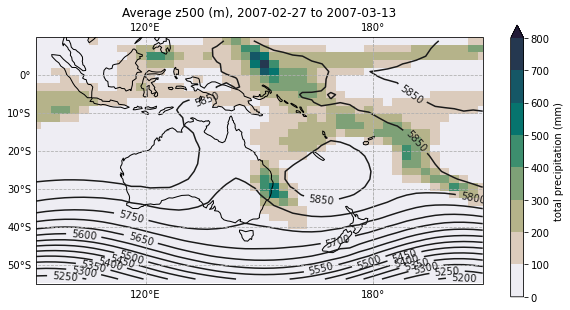

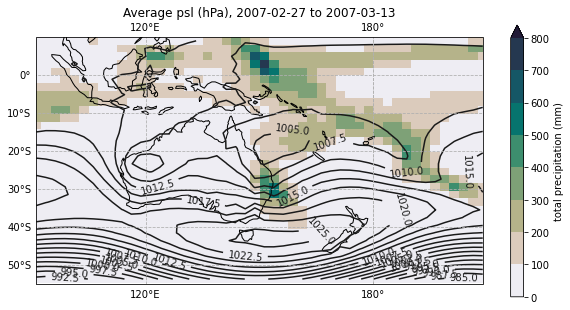

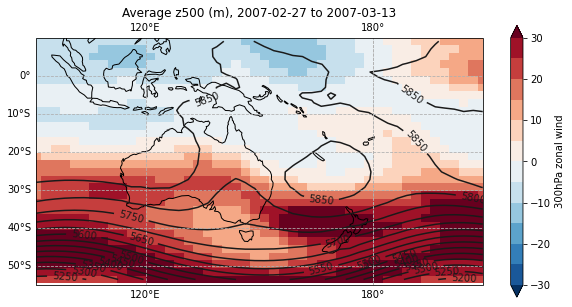

19980501 9 1998-12-16


/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


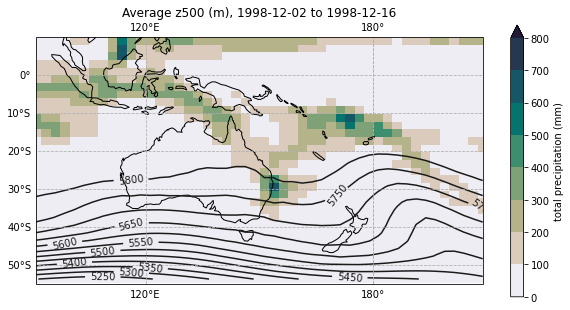

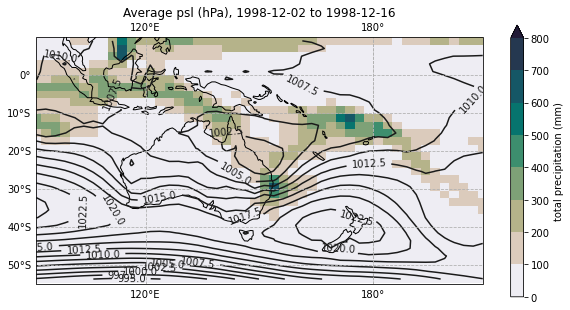

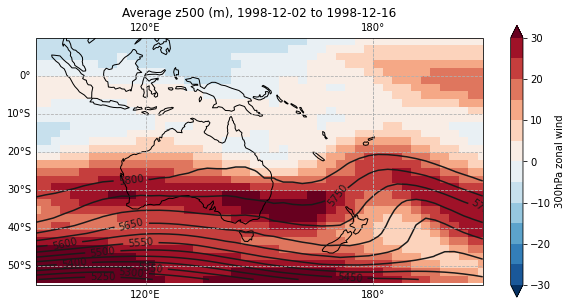

20041101 60 2014-03-25


/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


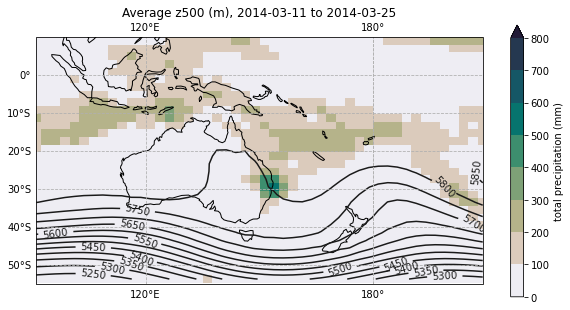

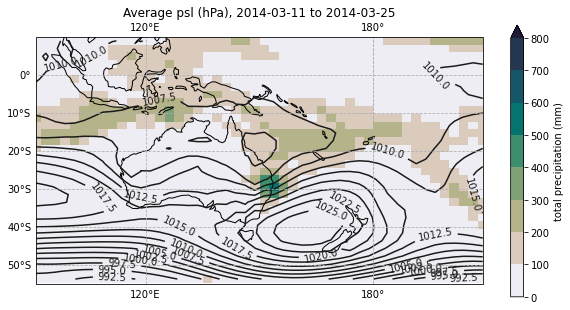

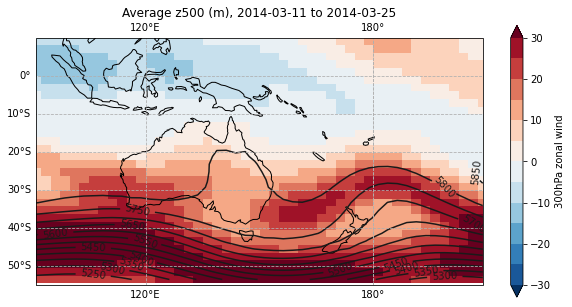

In [72]:
for init_date, ensemble, end_date in events:
    print(init_date, ensemble, end_date)
    atmos_file = f'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-{init_date}/atmos_isobaric_daily.zarr.zip'
    atmos_ds = fileio.open_dataset(
        atmos_file,
        metadata_file='/home/599/dbi599/unseen/config/dataset_cafe_daily.yml',
        variables=['h500', 'slp', 'pr', 'ucomp'],
        spatial_coords=[-55, 10, 90, 210]
    )
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    z500_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['h500']
    pr_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['slp']
    ua300_da = atmos_ds.sel({'ensemble': ensemble, 'level': 300, 'time': slice(start_date, end_date)})['ucomp']

    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
    plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
    plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)